In [35]:
import torch
from abc import ABC, abstractmethod
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wfdb
import ast
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import scipy


class Preprocessor(ABC):
    @abstractmethod
    def process(self, data):
        pass

class WaveletDenoiserWithThresholdPerLevel(Preprocessor):
    def __init__(self, wavelet='db4', level=4, threshold_type='soft'):
        self.wavelet = wavelet
        self.level = level
        if threshold_type not in ['soft', 'hard']:
            raise ValueError("Invalid threshold type. Select either 'soft' or 'hard'.")
        self.threshold_type = threshold_type

    def threshold_func(self, x, threshold, mode):
        if mode == 'soft':
            return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
        elif mode == 'hard':
            return x * (np.abs(x) > threshold)

    def process(self, ecg_signal):
        # Decompose the signal using DWT
        coeffs = pywt.wavedec(ecg_signal, self.wavelet, level=self.level)

        # Denoise the wavelet coefficients
        denoised_coeffs = []
        for i in range(len(coeffs)):
            if i == 0:  # do not denoise approximation coeffs at coarsest level
                denoised_coeffs.append(coeffs[i])
            else:
                # Determine the threshold for denoising
                sigma = np.median(np.abs(coeffs[i] - np.median(coeffs[i]))) / 0.6745
                threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
                denoised_coeffs.append(self.threshold_func(coeffs[i], threshold,
                                                           self.threshold_type))

        # Reconstruct the denoised signal
        return pywt.waverec(denoised_coeffs, self.wavelet)


In [36]:
def load_raw_data(df, sampling_rate, path):
    x=0
    if sampling_rate == 500:
        data = []
        for f in df.filename_lr:
            data.append(wfdb.rdsamp(path+f))
    else:
        data = []
        for f in df.filename_hr:
            data.append(wfdb.rdsamp(path+f))
    data = np.array([signal for signal, meta in data])
    return data

path = '/home/oopsie/Documents/PSIML/Projekat/physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100
# load and convert annotation data
Y = pd.read_csv('/home/oopsie/Documents/PSIML/Projekat/physionet.org/ptbxl_database1.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [37]:
column_name_to_drop1 = ['age','sex','height','weight','nurse','site','device','recording_date','report','heart_axis','infarction_stadium1','infarction_stadium2']
column_name_to_drop2= ['validated_by','second_opinion','initial_autogenerated_report','validated_by_human','filename_lr'] 
Y.drop(column_name_to_drop1, axis=1,inplace=True)
Y.drop(column_name_to_drop2, axis=1,inplace=True)
Y.drop('static_noise',axis=1,inplace=True)
print(len(Y))
print(Y.isna().sum())

26
patient_id              0
scp_codes               0
baseline_drift         19
burst_noise            26
electrodes_problems    26
extra_beats            23
pacemaker              26
strat_fold              0
filename_hr             0
dtype: int64


In [38]:
#extracted_values = Y.loc[Y['static_noise'].notna() & (Y['baseline_drift'].isna()) & (Y['electrodes_problems'].isna()) & (Y['extra_beats'].isna())& (Y['pacemaker'].isna()), 'patient_id']
#values=extracted_values.to_numpy()
#print(values)
rows_with_nan = Y[Y['baseline_drift'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['burst_noise'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['electrodes_problems'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['extra_beats'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)
rows_with_nan = Y[Y['pacemaker'].notna()].index.tolist()
Y.drop(rows_with_nan, inplace=True)



In [43]:
X = load_raw_data(Y, sampling_rate, path)
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('/home/oopsie/Documents/PSIML/Projekat/physionet.org/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    x=0
    for key in y_dic.keys():
        x+=1
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
print(Y)
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
249840
# Split data into train and test
test_fold = 10

        patient_id                                   scp_codes baseline_drift  \
ecg_id                                                                          
1          15709.0    {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}            NaN   
2          13243.0                {'NORM': 80.0, 'SBRAD': 0.0}            NaN   
3          20372.0                  {'NORM': 100.0, 'SR': 0.0}            NaN   
7          16193.0                  {'NORM': 100.0, 'SR': 0.0}            NaN   
9          18792.0                  {'NORM': 100.0, 'SR': 0.0}            NaN   
10          9456.0                  {'NORM': 100.0, 'SR': 0.0}            NaN   
12         11031.0                {'NORM': 80.0, 'SBRAD': 0.0}            NaN   
13         19953.0                  {'NORM': 100.0, 'SR': 0.0}            NaN   
14         12925.0                  {'NORM': 100.0, 'SR': 0.0}            NaN   
17         13619.0  {'AFLT': 100.0, 'ABQRS': 0.0, 'AFIB': 0.0}            NaN   
18         13619.0          

In [39]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")


RAM Usage: 505.88 MB


In [40]:
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('NORM')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('MI')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('STTC')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('CD')).sum()
print(norm_count)
norm_count = Y['diagnostic_superclass'].apply(lambda x: x.count('HYP')).sum()
print(norm_count)


#3898      CD
#2124      HYP
#4302      MI
#8174    NORM 
#4144      STTC


KeyError: 'diagnostic_superclass'

In [44]:
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

del X
del Y

flattened_y_train = [item for sublist in y_train for item in sublist]
flattened_y_test = [item for sublist in y_test for item in sublist]

# Get all unique categories from flattened lists
all_categories = sorted(set(flattened_y_train + flattened_y_test))


# One-hot encode y_train
y_train_encoded = pd.DataFrame(0, index=range(len(y_train)), columns=all_categories)
for i, categories in enumerate(y_train):
    y_train_encoded.loc[i, categories] = 1

# One-hot encode y_test
y_test_encoded = pd.DataFrame(0, index=range(len(y_test)), columns=all_categories)
for i, categories in enumerate(y_test):
    y_test_encoded.loc[i, categories] = 1

# Convert to list of lists
y_train_encoded = y_train_encoded.values.tolist()
y_test_encoded = y_test_encoded.values.tolist()



In [9]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")


RAM Usage: 4910.50 MB


In [23]:
X_train_before=X_train.copy()
counter=0
for t in range(len(X_train)):
    for i in range(12):
        counter+=1
        denoiser = WaveletDenoiserWithThresholdPerLevel(wavelet='db4', level=4)
        X_train[t,:,i] = denoiser.process(X_train[t,:, i])
for t in range(len(X_test)):
    for i in range(12):
        counter+=1
        denoiser = WaveletDenoiserWithThresholdPerLevel(wavelet='db4', level=4)
        X_test[t,:,i] = denoiser.process(X_test[t,:, i])
print(counter)
        

192


In [ ]:
min_vals = np.min(X_train, axis=(0, 1), keepdims=True)
max_vals = np.max(X_train, axis=(0, 1), keepdims=True)
normal = (X_train - min_vals) / (max_vals - min_vals)

NameError: name 'normal' is not defined

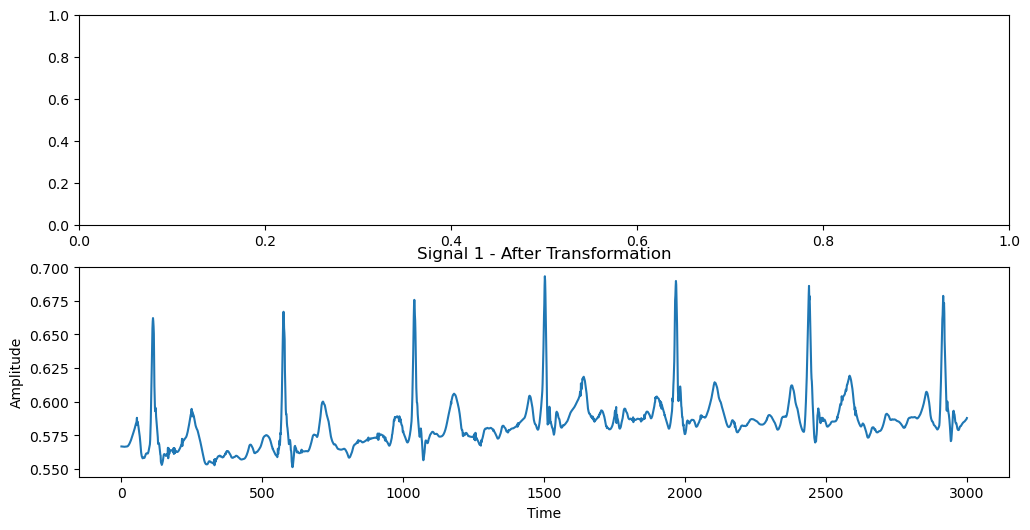

In [34]:
plt.figure(figsize=(12, 6))


# Plot the first signal after transformation
plt.subplot(2, 1, 2)
plt.plot(X_train[0,:3000,0])
plt.title(f'Signal {1} - After Transformation')
plt.xlabel('Time')
plt.ylabel('Amplitude')


# Plot the first signal before transformation
plt.subplot(2, 1, 1)
plt.plot(normal[0,:3000,0])
plt.title(f'Signal {1} - Before Transformation')
plt.xlabel('Time')
plt.ylabel('Amplitude')



plt.tight_layout()
plt.show()


In [32]:
class FlattenScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, 1))
        return self

    def transform(self, X, y=None):
        return self.scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

sc = FlattenScaler(MinMaxScaler())
X_train = sc.fit_transform(X_train)


#normalize with min max normalization train and test data
# Path: HYP copy.ipynb
sc = FlattenScaler(MinMaxScaler())
X_test = sc.fit_transform(X_test)

# Path: HYP copy.ipynb
#normalize with min max nor

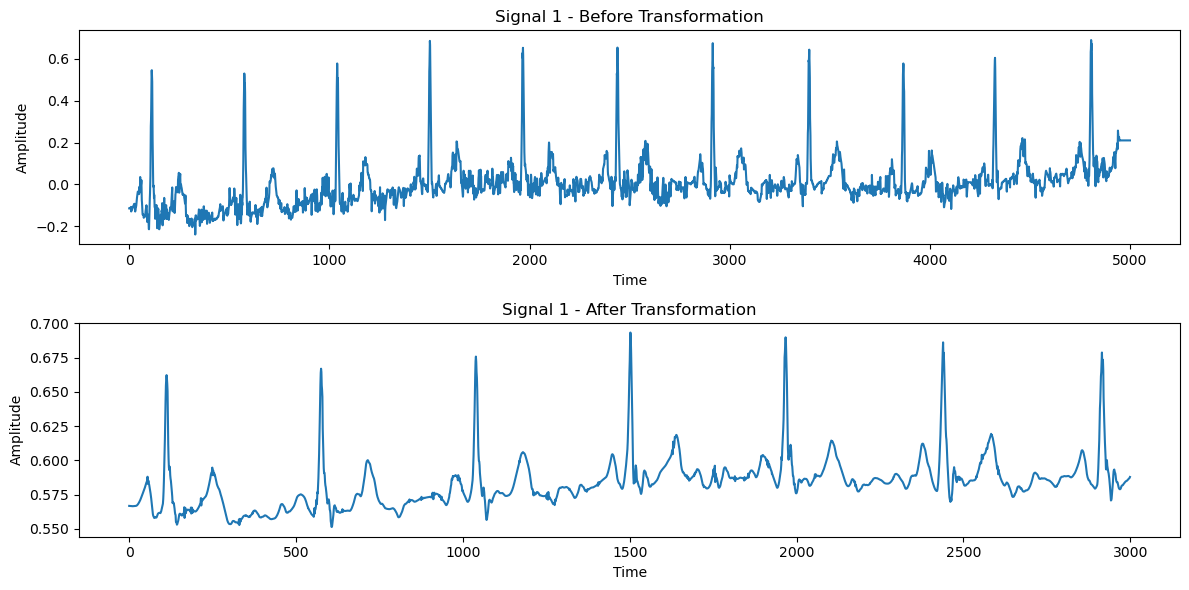

In [33]:
plt.figure(figsize=(12, 6))

# Plot the first signal before transformation
plt.subplot(2, 1, 1)
plt.plot(X_train_before[0,:,0])
plt.title(f'Signal {1} - Before Transformation')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the first signal after transformation
plt.subplot(2, 1, 2)
plt.plot(X_train[0,:3000,0])
plt.title(f'Signal {1} - After Transformation')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [32]:
#y_train=torch.tensor(y_train_encoded).repeat(4,1)
#= torch.tensor(y_train_encoded).repeat(4,1)

#y_test=torch.tensor(y_test_encoded).repeat(4,1)
#= torch.tensor(y_test_encoded).repeat(4,1)
print(y_train.shape)
print(y_test.shape)

y_train = y_train[:14592]
y_test = y_test[:1603]

torch.Size([58368, 5])
torch.Size([6412, 5])


In [14]:
X_train=X_train[:,500:4500,:]

X_train = np.split(X_train, 4, axis=1)

X_train = np.concatenate(X_train, axis=0)

X_test=X_test[:,500:4500,:]

X_test = np.split(X_test, 4, axis=1)

X_test = np.concatenate(X_test, axis=0)

print((X_train).shape)
print((X_test).shape)
print((y_train).shape)
print((y_test).shape)

(58368, 1000, 12)
(6412, 1000, 12)
torch.Size([58368, 5])
torch.Size([6412, 5])


In [33]:
print((X_train).shape)
print((X_test).shape)
print((y_train).shape)
print((y_test).shape)

(14592, 5000, 12)
(1603, 5000, 12)
torch.Size([14592, 5])
torch.Size([1603, 5])


In [34]:
print(np.count_nonzero(y_train[:, 0] == 1))
print(np.count_nonzero(y_train[:, 1] == 1))
print(np.count_nonzero(y_train[:, 2] == 1))
print(np.count_nonzero(y_train[:, 3] == 1))
print(np.count_nonzero(y_train[:, 4] == 1))

print(np.count_nonzero(y_test[:, 0] == 1))
print(np.count_nonzero(y_test[:, 1] == 1))
print(np.count_nonzero(y_test[:, 2] == 1))
print(np.count_nonzero(y_test[:, 3] == 1))
print(np.count_nonzero(y_test[:, 4] == 1))

cnt=0
for i in range(len(y_train)):
    if y_train[i,1]==1:
        cnt+=1
print(cnt)
cnt=0
for i in range(len(y_test)):
    if y_test[i,1]==1:
        cnt+=1
print(cnt)
y_train = y_train[:,2]


y_test = y_test[:,2]

cnt=0
for i in range(len(y_train)):
    if y_train[i]==1:
        cnt+=1
print(cnt)
cnt=0
for i in range(len(y_test)):
    if y_test[i]==1:
        cnt+=1
print(cnt)

print(y_train.shape)
print(y_test.shape)
print(y_train)
print(y_test)

3008
1266
3526
7132
3191
325
156
382
769
351
1266
156
3526
382
torch.Size([14592])
torch.Size([1603])
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0, 0, 0,  ..., 0, 0, 1])


In [35]:
y_train=torch.tensor(y_train)
y_test=torch.tensor(y_test)
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


/tmp/ipykernel_7733/1975836213.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train=torch.tensor(y_train)
/tmp/ipykernel_7733/1975836213.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test=torch.tensor(y_test)


In [36]:
class FlattenScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, 1))
        return self

    def transform(self, X, y=None):
        return self.scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

#sc = FlattenScaler(MinMaxScaler())
#X_train = sc.fit_transform(X_train)

X_train = torch.tensor(X_train, dtype=torch.float32)

X_test= torch.tensor(X_test, dtype=torch.float32)


X_valid=X_train[14000:,:,:] #ok
X_train=X_train[:14000,:,:] # ok


y_valid=y_train[14000:] #ok
y_train=y_train[:14000] # ok

# X_test , y_test_encoded
print((X_train).shape)
print((X_valid).shape)
print((X_test).shape)
print((y_train).shape)
print((y_valid).shape)
print((y_test).shape)

#X_train=torch.tensor(X_train,dtype=torch.float32)
#y_train=torch.tensor(np.array(y_train_encoded),dtype=torch.float32)
#print(y_train_encoded)
#print(X_train.shape)
#print(y_train.shape)
#print(type(X_test))
#print(type(y_test))

torch.Size([14000, 5000, 12])
torch.Size([592, 5000, 12])
torch.Size([1603, 5000, 12])
torch.Size([14000])
torch.Size([592])
torch.Size([1603])


In [55]:
print((X_train).shape)
print((X_valid).shape)
print((X_test).shape)
print((y_train).shape)
print((y_valid).shape)
print((y_test).shape)


print(type(X_train))
print(type(X_valid))
print(type(X_test))
print(type(y_train))
print(type(y_valid))
print(type(y_test))
#y_train = torch.from_numpy(y_train)
#y_valid = torch.from_numpy(y_valid)
#y_test = torch.from_numpy(y_test)


torch.Size([17316, 5000, 12])
torch.Size([592, 5000, 12])
torch.Size([1603, 5000, 12])
torch.Size([17316])
torch.Size([592])
torch.Size([1603])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [54]:
import torch


#indices = torch.nonzero(y_train == 1, as_tuple=False)[:, 0]
#selected_tensors = X_train[indices]
#num_selected_samples = selected_tensors.size(0)
#print(num_selected_samples)
## Concatenate the selected tensors at the end of X
#X_train = torch.cat((X_train, selected_tensors), dim=0)
#
ones_to_add = torch.ones(size=(num_selected_samples,), dtype=torch.int16)
y_train = torch.cat((y_train, ones_to_add), dim=0)


print(X_train.shape)
print(y_train.shape)

torch.Size([17316, 5000, 12])
torch.Size([17316])


In [37]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

    """def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0"""

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [38]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")



RAM Usage: 3765.31 MB


In [46]:
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=12, num_classes=1, kernel_size=5):
        super(SimpleCNN, self).__init__()
        
         # First Conv1D layer
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size, padding=2)
        
        # Second Conv1D layer
        self.conv2 = nn.Conv1d(32, 64, kernel_size, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size, padding=2)
        
        self.linear = nn.Linear(128*625, 32)
        self.output = nn.Linear(32, num_classes)

    def forward(self, x):
        # Forward pass through the layers
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool1d(x, 2)
        
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool1d(x, 2)
        
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool1d(x, 2)

        # Flatten the output before the linear layer
        x = x.view(x.size(0), -1)
        
        x = nn.functional.relu(self.linear(x))
        x = torch.sigmoid(self.output(x))
        
        return x
    

In [58]:
#y_train = torch.tensor(y_train).squeeze()

class_weight = torch.tensor(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=np.array(y_train).flatten()), dtype=torch.float32)
print(class_weight)

tensor([0.8104, 1.3055])


In [40]:
print(type(X_train))
print(type(X_valid))
print(type(y_train))
print(type(y_valid))
print((X_train).shape)
print((X_valid).shape)
print((y_train).shape)
print((y_valid).shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([14000, 5000, 12])
torch.Size([592, 5000, 12])
torch.Size([14000])
torch.Size([592])


torch.Size([14000, 5000, 12])


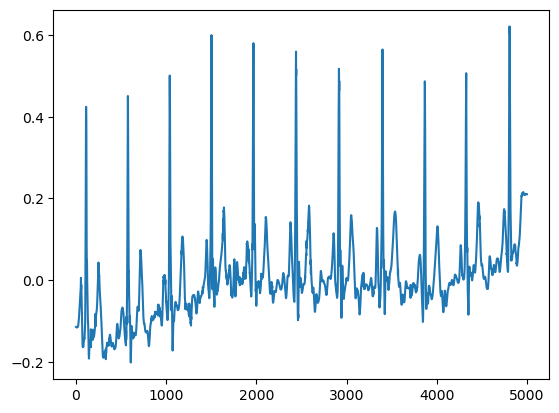

In [41]:
class NoisyECGDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        noisy_signal = self.add_random_noise(signal)
        return noisy_signal

    def add_random_noise(self, signal):
        signal = signal.numpy()
        
        magnitude_warp = np.random.normal(1, 0.1, signal.shape)
        signal = signal + magnitude_warp*signal# magnitude warp

        scale = np.random.normal(1, 0.05)
        signal = scale*signal  # rescale

        noise = np.random.normal(0, 0.01, signal.shape)
        signal = noise + signal  # static noise

        return torch.from_numpy(signal)

#print(X_train.shape)
train_dataset = NoisyECGDataset(X_train).data
plt.plot(train_dataset[0,:,0])
X_train=train_dataset
print(X_train.shape)

In [61]:
from tqdm import tqdm

import torch
import torchvision.transforms as transforms


#mean = X_train.mean()
#std = X_train.std()
## Define a normalization transform
#transform = transforms.Compose([
#    transforms.ToTensor(),  # Convert data to tensor (if not already)
#    transforms.Normalize(mean, std)  # Normalize the data
#])
## Apply the normalization transform to your training and test data
#normalized_X_train = transform(np.array(X_train))
#normalized_X_test = transform(np.array(X_test))


print(torch.cuda.is_available())
device=torch.device('cpu')
# Initialize the model         #10000 15000 512
epochs=30
num_classes = 1
learn_rate=0.000005
model=SimpleCNN()
model.to(device)
batch=2
# Define loss function and optimizer
#class_weight[1] *= 2.0
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1]).clone().detach())
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
#X_train_tensor_normalized=sc.transform(X_train_tensor)
# Create DataLoader for training and testing

train_dataset = TensorDataset(X_train.permute(0,2,1), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
total_train_batches = len(train_loader)
valid_dataset = TensorDataset(X_test.permute(0,2,1), y_test)
valid_loader = DataLoader(valid_dataset, batch_size=batch)


best_validation_loss = float('inf')
train_loss_values = []
train_accuracy_values = []
average_validation_loss=0.0
average_train_loss=0.0
valid_loss_values=[]
valid_accuracy_values=[]
metrics=[]
plt.ion()
total_loss=0.0
early_stopping = EarlyStopping(patience=6, verbose=True)
# training and testing
pom=0
for epoch in range(epochs):
    total_loss = 0.0
    correct_predictions = 0
    correct_predictions_for_1=0
    correct_predictions_for_0=0
    total_samples = 0
    with tqdm(total=total_train_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs)
            labels = labels.view(-1, 1)
            #print(labels)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_samples += len(labels)
            pred = outputs>0.5
            correct_predictions += (pred == labels).all(dim=1).sum().item()
            correct_predictions_for_1 += np.sum((pred.numpy() == 1) & (labels.numpy() == 1))
            correct_predictions_for_0 += np.sum((pred.numpy() == 0) & (labels.numpy() == 0))
            # Update the progress bar
            pbar.set_postfix({'Training Loss': f'{total_loss / total_samples:.4f}'})
            pbar.update(1)
    #print(correct_predictions_for_1)
    #print(correct_predictions_for_0)
    average_train_loss = total_loss / total_samples
    epoch_loss = total_loss / total_samples
    epoch_acc = float(correct_predictions) / total_samples
    train_loss_values.append(epoch_loss)
    train_accuracy_values.append(epoch_acc)
    print(f'{epoch + 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
            total_samples += len(labels)
            pred = (outputs > 0.5)
            correct_predictions += (pred == labels).all(dim=1).sum().item()
    average_validation_loss = total_loss / total_samples
    epoch_loss = total_loss/ total_samples
    epoch_acc = float(correct_predictions) / total_samples
    valid_loss_values.append(epoch_loss)
    valid_accuracy_values.append(epoch_acc)
    print(f'Epoch {epoch + 1} Validation Loss: {epoch_loss:.4f} Validation Acc: {epoch_acc:.4f}')
    early_stopping(average_validation_loss, model)
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        torch.save(model.state_dict(), 'best_model.pth')  
    if early_stopping.early_stop:
        print("Early stopping: Validation loss did not improve in the last", early_stopping.patience, "epochs.")
        break

plt.ioff()
plt.figure()

# Plot Training Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Validation Loss and Validation Accuracy
plt.figure()
plt.plot(valid_loss_values, label='Validation Loss')
plt.plot(valid_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

/tmp/ipykernel_7733/650065608.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1]).clone().detach())


False


Epoch 1/30:   0%|          | 7/8658 [00:00<03:28, 41.54batch/s, Training Loss=0.3469]

Epoch 1/30: 100%|██████████| 8658/8658 [04:08<00:00, 34.81batch/s, Training Loss=0.3913]


1 Loss: 0.3913 Acc: 0.6170


ValueError: Target size (torch.Size([2])) must be the same as input size (torch.Size([2, 1]))

In [16]:
import psutil

# Get the current process ID (PID)
pid = psutil.Process()

# Get the memory information
memory_info = pid.memory_info()

# RAM usage in bytes
ram_usage_bytes = memory_info.rss

# Convert bytes to megabytes (MB) for a more readable output
ram_usage_mb = ram_usage_bytes / (1024 * 1024)

print(f"RAM Usage: {ram_usage_mb:.2f} MB")



RAM Usage: 6282.99 MB
